In [2]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report
import os

In [4]:
logging.basicConfig(
    filename='./logs/churn_eda.log',
    level=logging.INFO,
    filemode='w',
    format='%(name)s - %(levelname)s - %(message)s')

In [5]:

os.environ['QT_QPA_PLATFORM']='offscreen'

In [6]:
# Global/Constant Variables
CAT_COLUMNS = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

QUANT_COLUMNS = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

KEEP_COLS = ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']

In [20]:
def import_data(pth):
    '''
    returns dataframe for the csv found at pth

    input:
        pth: a path to the csv
    output:
        df: pandas dataframe
    '''
    if not os.path.isfile(pth):
        raise FileNotFoundError

    df = pd.read_csv(pth)
    
    return df

In [8]:
def preprocess_data(df):
    '''
    returns dataframe with initial preprocessing needed (not feature engineering)

    input:
        df: pd Dataframe
    output:
        df: pandas dataframe
    '''
    df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)
    
    return df

In [21]:
def perform_eda(df):
    '''
    perform eda on df and save figures to images folder
    input:
        df: pandas dataframe

    output:
        None
    '''
    logging.info('DataFrame Shape: %s\n', df.shape)
    logging.info('Feature Null Count: \n%s', df.isnull().sum())
    logging.info('Descriptive metrics:\n%s', df.describe())
    
    # Viz EDA
    
    # Churn Histogram
    plt.figure(figsize=(20,10)) 
    df['Churn'].hist();
    plt.title('Churn Histogram')
    plt.savefig('./images/churn_histogram.jpeg')
    plt.close()
    
    # Customer Age hist
    plt.figure(figsize=(20,10)) 
    df['Customer_Age'].hist();
    plt.title('Customer Age Histogram')
    plt.savefig('./images/customer_age.jpeg')
    plt.close()
    
    # Marital Status Count Plot
    plt.figure(figsize=(20,10)) 
    sns.countplot(data=df, x='Marital_Status')
    plt.title('Marital Status Count Plot')
    plt.savefig('./images/marital_status_count.jpeg')
    plt.close()
    
    plt.figure(figsize=(20,10)) 
    # Show distributions of 'Total_Trans_Ct' and add a smooth curve obtained using a kernel density estimate
    sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True);
    plt.title('Total Transactions Ct')
    plt.savefig('./images/total_trans_ct_kernel_density.jpeg')
    plt.close()
    
    plt.figure(figsize=(20,10)) 
    sns.scatterplot(data=df, x='Avg_Open_To_Buy', y='Avg_Utilization_Ratio')
    plt.title('Avg Open To Buy vs Avg Utilization Ratio')
    plt.savefig('./images/scatter_open_to_buy_utilization.jpeg')
    plt.close()
    
    plt.figure(figsize=(20,10)) 
    sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2)
    plt.savefig('./images/corr_plot.jpeg')
    plt.close()

In [10]:
def encoder_helper(df, category_lst, response):
    '''
    helper function to turn each categorical column into a new column with
    propotion of churn for each category - associated with cell 15 from the notebook

    input:
        df: pandas dataframe
        category_lst: list of columns that contain categorical features
        response: string of response name [optional argument that could be used for naming variables or index y column]

    output:
        df: pandas dataframe with new columns for
    '''
    for cat in category_lst:
        df = df.merge(df.groupby(cat).mean()[response].to_frame(
            f'{cat}_{response}').reset_index(), on=cat)

    return df

# df_aux = df.copy()
# encoder_helper(df_aux, CAT_COLUMNS, 'Churn')


In [11]:
def perform_feature_engineering(df, response):
    '''
    input:
          df: pandas dataframe
          response: string of response name [optional argument that could be used for naming variables or index y column]

    output:
          X_train: X training data
          X_test: X testing data
          y_train: y training data
          y_test: y testing data
    '''
    
    y = df[response]
    
    X = encoder_helper(df, CAT_COLUMNS, response)

    X = X[KEEP_COLS].copy() 
    
    # train test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

    # train test split 
    return X_train, X_test, y_train, y_test

In [12]:
def train_models(X_train, X_test, y_train, y_test):
    '''
    train, store model results: images + scores, and store models
    input:
          X_train: X training data
          X_test: X testing data
          y_train: y training data
          y_test: y testing data
    output:
          None
    '''
    # This cell may take up to 15-20 minutes to run
    # grid search
    rfc = RandomForestClassifier(random_state=42)
    # Use a different solver if the default 'lbfgs' fails to converge
    # Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth' : [4,5,100],
        'criterion' :['gini', 'entropy']
    }

    cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
    cv_rfc.fit(X_train, y_train)

    lrc.fit(X_train, y_train)

    y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
    y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

    y_train_preds_lr = lrc.predict(X_train)
    y_test_preds_lr = lrc.predict(X_test)

    
    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off');
    plt.savefig('./images/rf_classification_report.jpeg')
    plt.close()
    
    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off');
    plt.savefig('./images/lr_classification_report.jpeg')
    plt.close()
    
    lrc_plot = plot_roc_curve(lrc, X_test, y_test)
    
    # plots
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
    lrc_plot.plot(ax=ax, alpha=0.8)
    plt.savefig('./images/models_roc_curve_comparison.jpeg')
    plt.show()
    
    # Saving models
    joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
    joblib.dump(lrc, './models/logistic_model.pkl')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

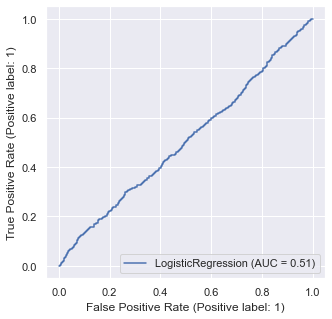

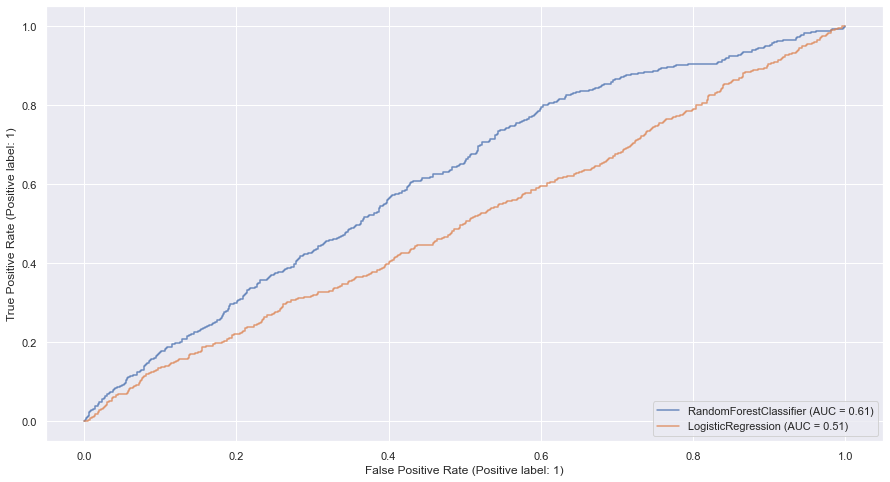

In [55]:
train_models(*perform_feature_engineering(df, 'Churn'))

In [51]:
def feature_importance_plot(model, X_data, output_pth):
    '''
    creates and stores the feature importances in pth
    input:
        model: model object containing feature_importances_
        X_data: pandas dataframe of X values
        output_pth: path to store the figure

    output:
         None
    '''

    explainer = shap.TreeExplainer(
        model)
    shap_values = explainer.shap_values(X_data)
    shap.summary_plot(shap_values, X_data, plot_type="bar")
    plt.savefig(
        os.path.join(
            output_pth, 'shap_feature_importance.jpeg'))
    plt.close()

    # Calculate feature importances
    importances = model.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [X_data.columns[i] for i in indices]

    # Create plot
    plt.figure(figsize=(20, 5))

    # Create plot title
    plt.title("Feature Importance")
    plt.ylabel('Importance')

    # Add bars
    plt.bar(range(X_data.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(X_data.shape[1]), names, rotation=90)
    plt.savefig(
        os.path.join(
            output_pth, 'normal_feature_importance.jpeg'))
    plt.close()

In [14]:
model = joblib.load('./models/rfc_model.pkl')

In [19]:
def predict(model, X_data, output_pth):
    '''
    Churn predictions given the data in X_data 
    input:
        model: model object containing feature_importances_
        X_data: pandas dataframe of X values
        output_pth: path to store predictions in csv

    output:
         pred_df: Pandas DataFrame containing the predictions
    '''
    
    predictions = model.predict(X_data)
    
    pred_df = pd.DataFrame(predictions, columns=['prediction'])
    
    pred_df.to_csv(output_pth, index=False)
    
    return pred_df

predict(model, X_data, output_pth='./data/predictions.csv')

,prediction
0,0
1,0
2,0
3,0
4,0
...,...
7083,0
7084,0
7085,0
7086,0
